In [41]:
import glob, sys
from datetime import date
import pickle
from random import randint
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.learning_curve import learning_curve
from sklearn import preprocessing
from sklearn.decomposition import PCA




class Trainer():
    #For the ML algorithm: SVM

    def __init__(data):
        #Split the data set into train,validation and test
        print ("Tainer class is being loaded...")
        data.start_time = time()
        data.loadData('data.pickle')
        data.splitTrainTest(data.labels, data.features)

    def loadData(inp, fileName):
        #Load the data set
        #Arguments:
        #fileName -- name of the cleaned dataset
        
        print ("Loading Data...")
        f = open('train.pkl', 'rb')
        finalData = pickle.load(f)

        inp.labels = finalData['loan_status'].values
        feature_names = list(finalData.columns.values)
        feature_names.remove('loan_status')
        inp.features = finalData[feature_names].values
        print ("The data is loaded with ", len(feature_names), " dimensions")

        time_elapsed = time() - inp.start_time
        print ("Time Elapsed: %0.2f s" % time_elapsed)

    def splitTrainTest(inp, labels, features):
        #Split th data into training and test datasets
        #Split the data into training and test set, further split the training data to training
        # and validation sets
        inp.X_train, inp.X_test, inp.y_train, inp.y_test = train_test_split(features,labels,test_size=0.001)
        inp.X_train, inp.X_cv, inp.y_train, inp.y_cv = train_test_split(inp.X_train, inp.y_train, test_size=0.5)

        print ("Total loans in traing set: " , len(inp.y_train))
        print ("number of defaults in training set: ", np.sum(inp.y_train == 0))
        print ("Total loans in validation set: " , len(inp.y_cv))
        print ("number of defaults in validation set: ", np.sum(inp.y_cv == 0))
        print ("Total loand in test set: " , len(inp.y_test))
        print ("number of defaults in test set: ", np.sum(inp.y_test == 0))

        time_elapsed = time() - inp.start_time
        print ("Time Elapsed: %0.2f s" %time_elapsed)

    

    def defineSVC(inp, C=1.0, kernel='rbf', degree=3, gamma=0.0, coef0=0.0, shrinking=True, 
                  probability=True, tol=0.01, cache_size=200, class_weight='auto', verbose=True, 
                  max_iter=-1, random_state=None):
        #defining Support Vector Machine, see scikit documentation for arguments
        # inp.clf -- classifier instance
      
        print ("--------SVM------")
        inp.clf = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, coef0=coef0, shrinking=shrinking, 
                  probability=probability, tol=tol, cache_size=cache_size, class_weight=class_weight, verbose=verbose, 
                  max_iter=max_iter, random_state=random_state)
        print (inp.clf.get_params())

    def trainCLF(inp):
        print ("Training the Classifier...")
        inp.clf.fit(inp.X_train, inp.y_train)

        time_elapsed = time() - inp.start_time
        print ("Time Elapsed: %0.2f s" %time_elapsed)

    def getScores(inp, X, y):
        #get the scores of the classifier: test data or CV
        #Not from the scikit lib: calculated with formulae
        print ("Running the classifier for scores ...")
        #if len(inp.X_train)>50:
        #print("NO PCA")

        pred = inp.clf.predict(X)
        tp = np.sum((pred == 1) & (y == 1))*1.0 #Use *1.0 instead of float for fast computation
        tpr = tp / np.sum(y == 1)
        fp = np.sum((pred == 1) & (y == 0))*1.0
        fpr = fp / np.sum(y == 0)
        fn = np.sum((pred == 0) & (y == 1))*1.0
        fnr =  fn / np.sum(y == 1)
        tn = np.sum((pred == 0) & (y == 0))*1.0
        tnr = tn / np.sum(y == 0)
        

        print ("tpr - predict paid actually paid")
        print ("fpr - predict paid actually default")
        print ("fnr - predict default actually paid")
        print ("tnr - predict default actually default")

        print ("tp: %0.3f" %tp)
        print ("tpr: %0.3f" %tpr)
        print ("fp: %0.3f" %fp)
        print ("fpr: %0.3f" %fpr)
        print ("fn: %0.3f" %fn)
        print ("fnr: %0.3f" %fnr)
        print ("tn: %0.3f" %tn)
        print ("tnr: %0.3f" %tnr)

        print ("toal default rate in the set: " , np.sum(y == 0)*1.0 / np.size(y))
        print ("predicted default rate: " , np.sum((pred == 1) & (y == 0))*1.0 / np.sum(pred == 1))
        print ("\n")
        
        time_elapsed = time() - inp.start_time
        print ("Time Elapsed: %0.2f s" %time_elapsed)

        return [tpr, fpr, fnr, tnr]

    def standardizeSamples(inp):
        """Scale all features to 0 mean and unit variance"""
        inp.X_train = preprocessing.scale(inp.X_train)
        inp.X_test = preprocessing.scale(inp.X_test)
        inp.X_cv = preprocessing.scale(inp.X_cv)

    def scaleSamplesToRange(inp):
        """Scale all features to values between 0 and 1"""
        minMaxScaler = preprocessing.MinMaxScaler()
        inp.X_train = minMaxScaler.fit_transform(inp.X_train)
        inp.X_test = minMaxScaler.fit_transform(inp.X_test)
        inp.X_cv = minMaxScaler.fit_transform(inp.X_cv)

    def normalizeSamples(inp):
        """Normalize all features to unity using l2 norm"""
        inp.X_train = preprocessing.normalize(inp.X_train, norm='l2')
        inp.X_test = preprocessing.normalize(inp.X_test, norm='l2')
        inp.X_cv = preprocessing.normalize(inp.X_cv, norm='l2')

    def getRandomSamples(inp, sample_size, X, y):
        #Generate Random samples from training data: to compute the learning curve(using subset)
        #sample_size--Number of samples to be returned
        #Return-X_subset and Y_subset
        train_size = sample_size*1.0 / np.size(y)
        _X_ignore, X_subset, _y_ignore, y_subset = train_test_split(X, y, test_size=train_size)
        return [X_subset, y_subset]

    def computeLearningCurve(inp, min_samples=1000, max_samples=10000, step_size=1000):
        ##Store values in arrays to plot at the end
        train_fpr = []
        cv_fpr = []
        sample_size = []

        for n in np.arange(min_samples, max_samples, step_size):
            for i in np.arange(1): #run each set of parameters multiple times to get some statistics
                training_data_subset = inp.getRandomSamples(n, inp.X_train, inp.y_train)
                X_train = training_data_subset[0]
                y_train = training_data_subset[1]

                print ("\nTraining classifier on ", n, " samples ... ")
                inp.clf.fit(X_train, y_train)
                print ("Training Scores:")
                training_scores = inp.getScores(X_train, y_train)
                train_fpr.append(training_scores[1])

                cv_data_subset = inp.getRandomSamples(n, inp.X_cv, inp.y_cv)
                X_cv = cv_data_subset[0]
                y_cv = cv_data_subset[1]
                print ("Cross Validation Scores:")
                cv_scores = inp.getScores(X_cv, y_cv)
                cv_fpr.append(cv_scores[1])

                sample_size.append(n)

        time_elapsed = time() - inp.start_time
        print ("Time Elapsed: %0.2f s" %time_elapsed)

        plt.plot(sample_size, train_fpr, 'red', label='train', linewidth=0.5)
        plt.plot(sample_size, cv_fpr, 'blue', label='validation', linewidth=0.5)
        plt.xlabel('# of Training Samples')
        plt.ylabel('score')
        plt.legend(loc='best')
        plt.show()


    def runPCA(inp, n_components=None):
        print ("Running PCA Dimensionality Reduction with n_components = ", n_components)
        inp.pca = PCA(n_components=n_components)
        print("-------------------------")
        
        print("\nNumber of features in training set before PCA transform:",len(inp.X_train[1]))
        inp.X_train = inp.pca.fit_transform(inp.X_train)
        print ("Reduced data down to ", inp.pca.n_components_, " dimensions: ")
        print ("Transforming test data ...")
        inp.X_test = inp.pca.transform(inp.X_test)
        inp.X_cv = inp.pca.transform(inp.X_cv)
        
        print("Number of features in training set after PCA transform:",len(inp.X_train[1]))
        
        time_elapsed = time() - inp.start_time
        print ("Time Elapsed: %0.2f s" %time_elapsed)
        
        

    def runSVCGridSearch(inp):
        C_vals = [0.001, 0.01, 0.1, 0.5]
        gamma_vals = [1E-4, 1E-3, 1E-2, 1E-1, 1]

        for C in C_vals:
            for gamma in gamma_vals:
                print ("\n\n C: ", C, "  gamma: ", gamma)
                inp.defineSVC(C=C, gamma=gamma)
                inp.trainCLF()
                print ("Training Scores:")
                inp.getScores(inp.X_train, inp.y_train)
                print ("Testing Scores:")
                inp.getScores(inp.X_cv, inp.y_cv)


    def computeROC(inp):
        ##ROC Curves
        fpr = dict()
        tpr = dict()
        thresholds = dict()
        pred_proba = dict()
        n = [100]
        
        for j in n:

            pred_proba[j] = inp.clf.predict_proba(inp.X_cv)
            fpr[j], tpr[j], thresholds[j] = roc_curve(inp.y_cv, pred_proba[j][:, 1], pos_label=1)
            #auc=auc(tpr[j],fpr[j])
            #fpr[j], tpr[j], thresholds[j] = roc_curve(inp.y_cv, pos_label=1)

            # Plot of a ROC curve
            #plt.figure()
            plt.plot(fpr[j], tpr[j], label='ROC curve for %s classifiers' %j)
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic')
            plt.legend(loc="lower right")
            plt.show()
            



#Mimicking the trainer class
trainer = Trainer()
#Can run the individual functions inside the trainer by the sytax trainer.function(arguments)
trainer.runPCA(n_components=50)
trainer.scaleSamplesToRange()
trainer.standardizeSamples()
trainer.defineSVC(C=0.1, gamma=0.1, cache_size=2000)


#trainer.runSVCGridSearch()
#trainer.computeLearningCurve()

trainer.trainCLF()
print ("Training Scores:")
trainer.getScores(trainer.X_train, trainer.y_train)
print ("Testing Scores:")
trainer.getScores(trainer.X_test, trainer.y_test)
#trainer.computeLearningCurve(1, 10000, 1000)


Tainer class is being loaded...
Loading Data...
The data is loaded with  130  dimensions
Time Elapsed: 0.06 s
Total loans in traing set:  14560
number of defaults in training set:  2322
Total loans in validation set:  14560
number of defaults in validation set:  2380
Total loand in test set:  30
number of defaults in test set:  9
Time Elapsed: 0.15 s
Running PCA Dimensionality Reduction with n_components =  50
-------------------------

Number of features in training set before PCA transform: 130
Reduced data down to  50  dimensions: 
Transforming test data ...
Number of features in training set after PCA transform: 50
Time Elapsed: 0.73 s
--------SVM------
{'random_state': None, 'cache_size': 2000, 'class_weight': 'auto', 'C': 0.1, 'shrinking': True, 'decision_function_shape': None, 'degree': 3, 'tol': 0.01, 'probability': True, 'verbose': True, 'kernel': 'rbf', 'coef0': 0.0, 'gamma': 0.1, 'max_iter': -1}
Training the Classifier...
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Time Elapsed: 189.01 s
Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5270.000
tpr: 0.431
fp: 104.000
fpr: 0.045
fn: 6968.000
fnr: 0.569
tn: 2218.000
tnr: 0.955
toal default rate in the set:  0.159478021978
predicted default rate:  0.0193524376628


Time Elapsed: 204.21 s
Testing Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 4.000
tpr: 0.190
fp: 3.000
fpr: 0.333
fn: 17.000
fnr: 0.810
tn: 6.000
tnr: 0.667
toal default rate in the set:  0.3
predicted default rate:  0.428571428571


Time Elapsed: 204.24 s


[0.19047619047619047,
 0.33333333333333331,
 0.80952380952380953,
 0.66666666666666663]


Training classifier on  10  samples ... 
[LibSVM]Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7.000
tpr: 1.000
fp: 3.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.3
algorithm's default rate:  0.3


Time Elapsed: 295.64 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 9.000
tpr: 1.000
fp: 1.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.1
algorithm's default rate:  0.1


Time Elapsed: 295.64 s

Training classifier on  60  samples ... 
[LibSVM]Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr 

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\ipykernel\__main__.py:121: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\Sri Lakshmi\Anaconda3\lib\site-pa

Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 220.000
fnr: 1.000
tn: 40.000
tnr: 1.000
total default rate:  0.153846153846
algorithm's default rate:  nan


Time Elapsed: 295.86 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 224.000
fnr: 1.000
tn: 36.000
tnr: 1.000
total default rate:  0.138461538462
algorithm's default rate:  nan


Time Elapsed: 295.87 s

Training classifier on  310  samples ... 
[LibSVM]Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default act

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 287.000
tpr: 1.000
fp: 73.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.202777777778
algorithm's default rate:  0.202777777778


Time Elapsed: 296.04 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 293.000
tpr: 1.000
fp: 67.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.186111111111
algorithm's default rate:  0.186111111111


Time Elapsed: 296.07 s

Training classifier on  410  samples ... 
[LibSVM]Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.00

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 374.000
fnr: 1.000
tn: 86.000
tnr: 1.000
total default rate:  0.186956521739
algorithm's default rate:  nan


Time Elapsed: 296.31 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 390.000
fnr: 1.000
tn: 70.000
tnr: 1.000
total default rate:  0.152173913043
algorithm's default rate:  nan


Time Elapsed: 296.33 s

Training classifier on  510  samples ... 
[LibSVM]Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default act

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 481.000
tpr: 1.000
fp: 79.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.141071428571
algorithm's default rate:  0.141071428571


Time Elapsed: 296.71 s

Training classifier on  610  samples ... 
[LibSVM]Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 515.000
fnr: 1.000
tn: 95.000
tnr: 1.000
total default rate:  0.155737704918
algorithm's default rate:  nan


Time Elapsed: 296.91 s
Cross Validation Scores:
Running the classifier for scores ...


C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 508.000
fnr: 1.000
tn: 102.000
tnr: 1.000
total default rate:  0.167213114754
algorithm's default rate:  nan


Time Elapsed: 296.94 s

Training classifier on  660  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 550.000
tpr: 1.000
fp: 0.000
fpr: 0.000
fn: 0.000
fnr: 0.000
tn: 110.000
tnr: 1.000
total default rate:  0.166666666667
algorithm's default rate:  0.0


Time Elapsed: 297.18 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 554.000
tpr: 1.000
fp: 106.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.160606060606
algorithm's default rate:  0.160606060606


Time Elapsed: 297.21 s

Training classifier on  710  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 579.000
fnr: 1.000
tn: 131.000
tnr: 1.000
total default rate:  0.184507042254
algorithm's default rate:  nan


Time Elapsed: 297.48 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 602.000
fnr: 1.000
tn: 108.000
tnr: 1.000
total default rate:  0.152112676056
algorithm's default rate:  nan


Time Elapsed: 297.53 s

Training classifier on  760  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 635.000
fnr: 1.000
tn: 125.000
tnr: 1.000
total default rate:  0.164473684211
algorithm's default rate:  nan


Time Elapsed: 297.84 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 637.000
fnr: 1.000
tn: 123.000
tnr: 1.000
total default rate:  0.161842105263
algorithm's default rate:  nan


Time Elapsed: 297.88 s

Training classifier on  810  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 672.000
fnr: 1.000
tn: 138.000
tnr: 1.000
total default rate:  0.17037037037
algorithm's default rate:  nan


Time Elapsed: 298.25 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 678.000
fnr: 1.000
tn: 132.000
tnr: 1.000
total default rate:  0.162962962963
algorithm's default rate:  nan


Time Elapsed: 298.28 s

Training classifier on  860  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 711.000
tpr: 1.000
fp: 149.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.173255813953
algorithm's default rate:  0.173255813953


Time Elapsed: 298.68 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 721.000
tpr: 1.000
fp: 139.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.161627906977
algorithm's default rate:  0.161627906977


Time Elapsed: 298.75 s

Training classifier on  910  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 770.000
tpr: 1.000
fp: 0.000
fpr: 0.000
fn: 0.000
fnr: 0.000
tn: 140.000
tnr: 1.000
total default rate:  0.153846153846
algorithm's default rate:  0.0


Time Elapsed: 299.22 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 762.000
tpr: 0.996
fp: 145.000
fpr: 1.000
fn: 3.000
fnr: 0.004
tn: 0.000
tnr: 0.000
total default rate:  0.159340659341
algorithm's default rate:  0.1598676957


Time Elapsed: 299.28 s

Training classifier on  960  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 806.000
tpr: 1.000
fp: 154.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.160416666667
algorithm's default rate:  0.160416666667


Time Elapsed: 299.87 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 809.000
tpr: 1.000
fp: 151.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.157291666667
algorithm's default rate:  0.157291666667


Time Elapsed: 299.95 s

Training classifier on  1010  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 844.000
fnr: 1.000
tn: 166.000
tnr: 1.000
total default rate:  0.164356435644
algorithm's default rate:  nan


Time Elapsed: 300.53 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 837.000
fnr: 1.000
tn: 173.000
tnr: 1.000
total default rate:  0.171287128713
algorithm's default rate:  nan


Time Elapsed: 300.61 s

Training classifier on  1060  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 866.000
tpr: 1.000
fp: 194.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.183018867925
algorithm's default rate:  0.183018867925


Time Elapsed: 301.28 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 911.000
tpr: 1.000
fp: 149.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.140566037736
algorithm's default rate:  0.140566037736


Time Elapsed: 301.37 s

Training classifier on  1110  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 943.000
tpr: 1.000
fp: 167.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.15045045045
algorithm's default rate:  0.15045045045


Time Elapsed: 302.02 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 922.000
tpr: 1.000
fp: 188.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.169369369369
algorithm's default rate:  0.169369369369


Time Elapsed: 302.12 s

Training classifier on  1160  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 970.000
fnr: 1.000
tn: 190.000
tnr: 1.000
total default rate:  0.163793103448
algorithm's default rate:  nan


Time Elapsed: 302.83 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 971.000
fnr: 1.000
tn: 189.000
tnr: 1.000
total default rate:  0.162931034483
algorithm's default rate:  nan


Time Elapsed: 302.93 s

Training classifier on  1210  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 999.000
fnr: 1.000
tn: 211.000
tnr: 1.000
total default rate:  0.174380165289
algorithm's default rate:  nan


Time Elapsed: 303.77 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1011.000
fnr: 1.000
tn: 199.000
tnr: 1.000
total default rate:  0.164462809917
algorithm's default rate:  nan


Time Elapsed: 303.92 s

Training classifier on  1260  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1041.000
tpr: 1.000
fp: 219.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.17380952381
algorithm's default rate:  0.17380952381


Time Elapsed: 304.89 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1058.000
tpr: 1.000
fp: 202.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.160317460317
algorithm's default rate:  0.160317460317


Time Elapsed: 305.00 s

Training classifier on  1310  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1082.000
tpr: 1.000
fp: 228.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.174045801527
algorithm's default rate:  0.174045801527


Time Elapsed: 305.92 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1128.000
tpr: 1.000
fp: 182.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.13893129771
algorithm's default rate:  0.13893129771


Time Elapsed: 306.04 s

Training classifier on  1360  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1132.000
tpr: 1.000
fp: 228.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.167647058824
algorithm's default rate:  0.167647058824


Time Elapsed: 307.14 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1137.000
tpr: 1.000
fp: 223.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.163970588235
algorithm's default rate:  0.163970588235


Time Elapsed: 307.27 s

Training classifier on  1410  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1168.000
fnr: 1.000
tn: 242.000
tnr: 1.000
total default rate:  0.171631205674
algorithm's default rate:  nan


Time Elapsed: 308.32 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1214.000
fnr: 1.000
tn: 196.000
tnr: 1.000
total default rate:  0.139007092199
algorithm's default rate:  nan


Time Elapsed: 308.48 s

Training classifier on  1460  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1198.000
fnr: 1.000
tn: 262.000
tnr: 1.000
total default rate:  0.179452054795
algorithm's default rate:  nan


Time Elapsed: 309.69 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1234.000
fnr: 1.000
tn: 226.000
tnr: 1.000
total default rate:  0.154794520548
algorithm's default rate:  nan


Time Elapsed: 309.86 s

Training classifier on  1510  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1254.000
fnr: 1.000
tn: 256.000
tnr: 1.000
total default rate:  0.169536423841
algorithm's default rate:  nan


Time Elapsed: 311.21 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1287.000
fnr: 1.000
tn: 223.000
tnr: 1.000
total default rate:  0.147682119205
algorithm's default rate:  nan


Time Elapsed: 311.41 s

Training classifier on  1560  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1290.000
fnr: 1.000
tn: 270.000
tnr: 1.000
total default rate:  0.173076923077
algorithm's default rate:  nan


Time Elapsed: 312.84 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1310.000
fnr: 1.000
tn: 250.000
tnr: 1.000
total default rate:  0.160256410256
algorithm's default rate:  nan


Time Elapsed: 313.04 s

Training classifier on  1610  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1341.000
fnr: 1.000
tn: 269.000
tnr: 1.000
total default rate:  0.167080745342
algorithm's default rate:  nan


Time Elapsed: 314.58 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1358.000
fnr: 1.000
tn: 252.000
tnr: 1.000
total default rate:  0.15652173913
algorithm's default rate:  nan


Time Elapsed: 314.78 s

Training classifier on  1660  samples ... 


C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


[LibSVM]Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1385.000
fnr: 1.000
tn: 275.000
tnr: 1.000
total default rate:  0.165662650602
algorithm's default rate:  nan


Time Elapsed: 316.31 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1387.000
fnr: 1.000
tn: 273.000
tnr: 1.000
total default rate:  0.164457831325
algorithm's default rate:  nan


Time Elapsed: 316.51 s

Training classifier on  1710  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1430.000
tpr: 1.000
fp: 280.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.163742690058
algorithm's default rate:  0.163742690058


Time Elapsed: 318.15 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1431.000
tpr: 1.000
fp: 279.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.163157894737
algorithm's default rate:  0.163157894737


Time Elapsed: 318.36 s

Training classifier on  1760  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1489.000
fnr: 1.000
tn: 271.000
tnr: 1.000
total default rate:  0.153977272727
algorithm's default rate:  nan


Time Elapsed: 319.98 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1504.000
fnr: 1.000
tn: 256.000
tnr: 1.000
total default rate:  0.145454545455
algorithm's default rate:  nan


Time Elapsed: 320.18 s

Training classifier on  1810  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1486.000
tpr: 1.000
fp: 324.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.179005524862
algorithm's default rate:  0.179005524862


Time Elapsed: 321.87 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1517.000
tpr: 1.000
fp: 293.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.161878453039
algorithm's default rate:  0.161878453039


Time Elapsed: 322.11 s

Training classifier on  1860  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1562.000
fnr: 1.000
tn: 298.000
tnr: 1.000
total default rate:  0.160215053763
algorithm's default rate:  nan


Time Elapsed: 323.88 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1565.000
fnr: 1.000
tn: 295.000
tnr: 1.000
total default rate:  0.158602150538
algorithm's default rate:  nan


Time Elapsed: 324.12 s

Training classifier on  1910  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1598.000
tpr: 1.000
fp: 312.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.16335078534
algorithm's default rate:  0.16335078534


Time Elapsed: 325.98 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1594.000
tpr: 1.000
fp: 316.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.165445026178
algorithm's default rate:  0.165445026178


Time Elapsed: 326.24 s

Training classifier on  1960  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1609.000
fnr: 1.000
tn: 351.000
tnr: 1.000
total default rate:  0.179081632653
algorithm's default rate:  nan


Time Elapsed: 328.20 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1632.000
fnr: 1.000
tn: 328.000
tnr: 1.000
total default rate:  0.167346938776
algorithm's default rate:  nan


Time Elapsed: 328.47 s

Training classifier on  2010  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1672.000
tpr: 1.000
fp: 339.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.168572849329
algorithm's default rate:  0.168572849329


Time Elapsed: 330.53 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1695.000
tpr: 1.000
fp: 316.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.157135753357
algorithm's default rate:  0.157135753357


Time Elapsed: 330.80 s

Training classifier on  2060  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1687.000
fnr: 1.000
tn: 373.000
tnr: 1.000
total default rate:  0.181067961165
algorithm's default rate:  nan


Time Elapsed: 332.99 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1712.000
fnr: 1.000
tn: 348.000
tnr: 1.000
total default rate:  0.168932038835
algorithm's default rate:  nan


Time Elapsed: 333.29 s

Training classifier on  2110  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1756.000
fnr: 1.000
tn: 354.000
tnr: 1.000
total default rate:  0.167772511848
algorithm's default rate:  nan


Time Elapsed: 335.57 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1760.000
fnr: 1.000
tn: 350.000
tnr: 1.000
total default rate:  0.165876777251
algorithm's default rate:  nan


Time Elapsed: 335.89 s

Training classifier on  2160  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1801.000
fnr: 1.000
tn: 359.000
tnr: 1.000
total default rate:  0.166203703704
algorithm's default rate:  nan


Time Elapsed: 338.29 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1794.000
fnr: 1.000
tn: 366.000
tnr: 1.000
total default rate:  0.169444444444
algorithm's default rate:  nan


Time Elapsed: 338.61 s

Training classifier on  2210  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1831.000
fnr: 1.000
tn: 379.000
tnr: 1.000
total default rate:  0.17149321267
algorithm's default rate:  nan


Time Elapsed: 341.15 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1866.000
fnr: 1.000
tn: 344.000
tnr: 1.000
total default rate:  0.155656108597
algorithm's default rate:  nan


Time Elapsed: 341.48 s

Training classifier on  2260  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1910.000
fnr: 1.000
tn: 350.000
tnr: 1.000
total default rate:  0.154867256637
algorithm's default rate:  nan


Time Elapsed: 344.07 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1885.000
fnr: 1.000
tn: 375.000
tnr: 1.000
total default rate:  0.16592920354
algorithm's default rate:  nan


Time Elapsed: 344.42 s

Training classifier on  2310  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1926.000
fnr: 1.000
tn: 384.000
tnr: 1.000
total default rate:  0.166233766234
algorithm's default rate:  nan


Time Elapsed: 347.16 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1961.000
fnr: 1.000
tn: 349.000
tnr: 1.000
total default rate:  0.151082251082
algorithm's default rate:  nan


Time Elapsed: 347.53 s

Training classifier on  2360  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 1959.000
fnr: 1.000
tn: 401.000
tnr: 1.000
total default rate:  0.169915254237
algorithm's default rate:  nan


Time Elapsed: 350.40 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 2010.000
fnr: 1.000
tn: 350.000
tnr: 1.000
total default rate:  0.148305084746
algorithm's default rate:  nan


Time Elapsed: 350.78 s

Training classifier on  2410  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2023.000
tpr: 1.000
fp: 387.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.160580912863
algorithm's default rate:  0.160580912863


Time Elapsed: 353.74 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2008.000
tpr: 1.000
fp: 402.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.166804979253
algorithm's default rate:  0.166804979253


Time Elapsed: 354.14 s

Training classifier on  2460  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 2071.000
fnr: 1.000
tn: 389.000
tnr: 1.000
total default rate:  0.158130081301
algorithm's default rate:  nan


Time Elapsed: 357.22 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 2036.000
fnr: 1.000
tn: 424.000
tnr: 1.000
total default rate:  0.172357723577
algorithm's default rate:  nan


Time Elapsed: 357.64 s

Training classifier on  2510  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2105.000
tpr: 1.000
fp: 405.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.161354581673
algorithm's default rate:  0.161354581673


Time Elapsed: 360.86 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2111.000
tpr: 1.000
fp: 399.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.158964143426
algorithm's default rate:  0.158964143426


Time Elapsed: 361.29 s

Training classifier on  2560  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2120.000
tpr: 1.000
fp: 440.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.171875
algorithm's default rate:  0.171875


Time Elapsed: 364.83 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2143.000
tpr: 1.000
fp: 417.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.162890625
algorithm's default rate:  0.162890625


Time Elapsed: 365.27 s

Training classifier on  2610  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2154.000
tpr: 1.000
fp: 456.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.174712643678
algorithm's default rate:  0.174712643678


Time Elapsed: 368.80 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2201.000
tpr: 1.000
fp: 409.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.156704980843
algorithm's default rate:  0.156704980843


Time Elapsed: 369.27 s

Training classifier on  2660  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2228.000
tpr: 1.000
fp: 432.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.162406015038
algorithm's default rate:  0.162406015038


Time Elapsed: 372.91 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2201.000
tpr: 1.000
fp: 459.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.172556390977
algorithm's default rate:  0.172556390977


Time Elapsed: 373.42 s

Training classifier on  2710  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2256.000
tpr: 1.000
fp: 454.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.167527675277
algorithm's default rate:  0.167527675277


Time Elapsed: 377.22 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2273.000
tpr: 1.000
fp: 437.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.161254612546
algorithm's default rate:  0.161254612546


Time Elapsed: 377.73 s

Training classifier on  2760  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2316.000
tpr: 1.000
fp: 444.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.160869565217
algorithm's default rate:  0.160869565217


Time Elapsed: 381.69 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2342.000
tpr: 1.000
fp: 418.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.151449275362
algorithm's default rate:  0.151449275362


Time Elapsed: 382.20 s

Training classifier on  2810  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2346.000
tpr: 1.000
fp: 464.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.16512455516
algorithm's default rate:  0.16512455516


Time Elapsed: 386.30 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2348.000
tpr: 1.000
fp: 462.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.164412811388
algorithm's default rate:  0.164412811388


Time Elapsed: 386.84 s

Training classifier on  2860  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2398.000
tpr: 1.000
fp: 462.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.161538461538
algorithm's default rate:  0.161538461538


Time Elapsed: 391.08 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2393.000
tpr: 1.000
fp: 467.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.163286713287
algorithm's default rate:  0.163286713287


Time Elapsed: 391.67 s

Training classifier on  2910  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2431.000
tpr: 1.000
fp: 479.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.164604810997
algorithm's default rate:  0.164604810997


Time Elapsed: 396.15 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2463.000
tpr: 1.000
fp: 447.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.153608247423
algorithm's default rate:  0.153608247423


Time Elapsed: 396.72 s

Training classifier on  2960  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2481.000
tpr: 1.000
fp: 479.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.161824324324
algorithm's default rate:  0.161824324324


Time Elapsed: 401.38 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2497.000
tpr: 1.000
fp: 463.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.156418918919
algorithm's default rate:  0.156418918919


Time Elapsed: 401.99 s

Training classifier on  3010  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2490.000
tpr: 1.000
fp: 520.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.172757475083
algorithm's default rate:  0.172757475083


Time Elapsed: 406.68 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2504.000
tpr: 1.000
fp: 506.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.168106312292
algorithm's default rate:  0.168106312292


Time Elapsed: 407.31 s

Training classifier on  3060  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2543.000
tpr: 1.000
fp: 517.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.168954248366
algorithm's default rate:  0.168954248366


Time Elapsed: 412.25 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2541.000
tpr: 1.000
fp: 519.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.169607843137
algorithm's default rate:  0.169607843137


Time Elapsed: 412.92 s

Training classifier on  3110  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 2573.000
fnr: 1.000
tn: 537.000
tnr: 1.000
total default rate:  0.172668810289
algorithm's default rate:  nan


Time Elapsed: 418.08 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 2641.000
fnr: 1.000
tn: 469.000
tnr: 1.000
total default rate:  0.150803858521
algorithm's default rate:  nan


Time Elapsed: 418.77 s

Training classifier on  3160  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2641.000
tpr: 1.000
fp: 519.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.164240506329
algorithm's default rate:  0.164240506329


Time Elapsed: 424.00 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2652.000
tpr: 1.000
fp: 508.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.160759493671
algorithm's default rate:  0.160759493671


Time Elapsed: 424.68 s

Training classifier on  3210  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2695.000
tpr: 1.000
fp: 515.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.160436137072
algorithm's default rate:  0.160436137072


Time Elapsed: 430.01 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2675.000
tpr: 1.000
fp: 535.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.166666666667
algorithm's default rate:  0.166666666667


Time Elapsed: 430.72 s

Training classifier on  3260  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 2715.000
fnr: 1.000
tn: 545.000
tnr: 1.000
total default rate:  0.16717791411
algorithm's default rate:  nan


Time Elapsed: 436.31 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 2738.000
fnr: 1.000
tn: 522.000
tnr: 1.000
total default rate:  0.160122699387
algorithm's default rate:  nan


Time Elapsed: 437.04 s

Training classifier on  3310  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2754.000
tpr: 1.000
fp: 556.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.167975830816
algorithm's default rate:  0.167975830816


Time Elapsed: 442.69 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2799.000
tpr: 1.000
fp: 511.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.154380664653
algorithm's default rate:  0.154380664653


Time Elapsed: 443.47 s

Training classifier on  3360  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2824.000
tpr: 1.000
fp: 536.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.159523809524
algorithm's default rate:  0.159523809524


Time Elapsed: 449.36 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2830.000
tpr: 1.000
fp: 530.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.157738095238
algorithm's default rate:  0.157738095238


Time Elapsed: 450.14 s

Training classifier on  3410  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2840.000
tpr: 1.000
fp: 570.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.16715542522
algorithm's default rate:  0.16715542522


Time Elapsed: 456.20 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2862.000
tpr: 1.000
fp: 548.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.160703812317
algorithm's default rate:  0.160703812317


Time Elapsed: 457.03 s

Training classifier on  3460  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 2935.000
fnr: 1.000
tn: 525.000
tnr: 1.000
total default rate:  0.151734104046
algorithm's default rate:  nan


Time Elapsed: 463.29 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 2916.000
fnr: 1.000
tn: 544.000
tnr: 1.000
total default rate:  0.157225433526
algorithm's default rate:  nan


Time Elapsed: 464.13 s

Training classifier on  3510  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 2896.000
fnr: 1.000
tn: 614.000
tnr: 1.000
total default rate:  0.174928774929
algorithm's default rate:  nan


Time Elapsed: 470.71 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 2986.000
fnr: 1.000
tn: 524.000
tnr: 1.000
total default rate:  0.149287749288
algorithm's default rate:  nan


Time Elapsed: 471.55 s

Training classifier on  3560  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 2933.000
fnr: 1.000
tn: 627.000
tnr: 1.000
total default rate:  0.176123595506
algorithm's default rate:  nan


Time Elapsed: 478.18 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3005.000
fnr: 1.000
tn: 555.000
tnr: 1.000
total default rate:  0.155898876404
algorithm's default rate:  nan


Time Elapsed: 479.07 s

Training classifier on  3610  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3014.000
fnr: 1.000
tn: 596.000
tnr: 1.000
total default rate:  0.165096952909
algorithm's default rate:  nan


Time Elapsed: 485.87 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3040.000
fnr: 1.000
tn: 570.000
tnr: 1.000
total default rate:  0.157894736842
algorithm's default rate:  nan


Time Elapsed: 486.76 s

Training classifier on  3660  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3070.000
fnr: 1.000
tn: 590.000
tnr: 1.000
total default rate:  0.161202185792
algorithm's default rate:  nan


Time Elapsed: 493.70 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3088.000
fnr: 1.000
tn: 572.000
tnr: 1.000
total default rate:  0.156284153005
algorithm's default rate:  nan


Time Elapsed: 494.63 s

Training classifier on  3710  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3100.000
fnr: 1.000
tn: 610.000
tnr: 1.000
total default rate:  0.164420485175
algorithm's default rate:  nan


Time Elapsed: 501.71 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3141.000
fnr: 1.000
tn: 569.000
tnr: 1.000
total default rate:  0.153369272237
algorithm's default rate:  nan


Time Elapsed: 502.67 s

Training classifier on  3760  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3098.000
fnr: 1.000
tn: 663.000
tnr: 1.000
total default rate:  0.176282903483
algorithm's default rate:  nan


Time Elapsed: 509.95 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3142.000
fnr: 1.000
tn: 619.000
tnr: 1.000
total default rate:  0.164583887264
algorithm's default rate:  nan


Time Elapsed: 510.92 s

Training classifier on  3810  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3192.000
fnr: 1.000
tn: 618.000
tnr: 1.000
total default rate:  0.162204724409
algorithm's default rate:  nan


Time Elapsed: 518.47 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3223.000
fnr: 1.000
tn: 587.000
tnr: 1.000
total default rate:  0.15406824147
algorithm's default rate:  nan


Time Elapsed: 519.47 s

Training classifier on  3860  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3203.000
fnr: 1.000
tn: 657.000
tnr: 1.000
total default rate:  0.170207253886
algorithm's default rate:  nan


Time Elapsed: 527.31 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3240.000
fnr: 1.000
tn: 620.000
tnr: 1.000
total default rate:  0.160621761658
algorithm's default rate:  nan


Time Elapsed: 528.33 s

Training classifier on  3910  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3274.000
fnr: 1.000
tn: 636.000
tnr: 1.000
total default rate:  0.162659846547
algorithm's default rate:  nan


Time Elapsed: 536.60 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3292.000
fnr: 1.000
tn: 618.000
tnr: 1.000
total default rate:  0.158056265985
algorithm's default rate:  nan


Time Elapsed: 537.67 s

Training classifier on  3960  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3308.000
fnr: 1.000
tn: 652.000
tnr: 1.000
total default rate:  0.164646464646
algorithm's default rate:  nan


Time Elapsed: 546.11 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3364.000
fnr: 1.000
tn: 596.000
tnr: 1.000
total default rate:  0.150505050505
algorithm's default rate:  nan


Time Elapsed: 547.17 s

Training classifier on  4010  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3312.000
fnr: 1.000
tn: 699.000
tnr: 1.000
total default rate:  0.174270755423
algorithm's default rate:  nan


Time Elapsed: 555.70 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3378.000
fnr: 1.000
tn: 633.000
tnr: 1.000
total default rate:  0.157816005984
algorithm's default rate:  nan


Time Elapsed: 556.83 s

Training classifier on  4060  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3399.000
fnr: 1.000
tn: 661.000
tnr: 1.000
total default rate:  0.162807881773
algorithm's default rate:  nan


Time Elapsed: 565.88 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3421.000
fnr: 1.000
tn: 639.000
tnr: 1.000
total default rate:  0.157389162562
algorithm's default rate:  nan


Time Elapsed: 567.05 s

Training classifier on  4110  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3392.000
fnr: 1.000
tn: 718.000
tnr: 1.000
total default rate:  0.174695863747
algorithm's default rate:  nan


Time Elapsed: 576.05 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3443.000
fnr: 1.000
tn: 667.000
tnr: 1.000
total default rate:  0.162287104623
algorithm's default rate:  nan


Time Elapsed: 577.23 s

Training classifier on  4160  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 3500.000
tpr: 1.000
fp: 660.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.158653846154
algorithm's default rate:  0.158653846154


Time Elapsed: 586.46 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 3504.000
tpr: 1.000
fp: 656.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.157692307692
algorithm's default rate:  0.157692307692


Time Elapsed: 587.67 s

Training classifier on  4210  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3505.000
fnr: 1.000
tn: 705.000
tnr: 1.000
total default rate:  0.167458432304
algorithm's default rate:  nan


Time Elapsed: 597.04 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3481.000
fnr: 1.000
tn: 729.000
tnr: 1.000
total default rate:  0.173159144893
algorithm's default rate:  nan


Time Elapsed: 598.26 s

Training classifier on  4260  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3533.000
fnr: 1.000
tn: 727.000
tnr: 1.000
total default rate:  0.170657276995
algorithm's default rate:  nan


Time Elapsed: 608.08 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3618.000
fnr: 1.000
tn: 642.000
tnr: 1.000
total default rate:  0.150704225352
algorithm's default rate:  nan


Time Elapsed: 609.30 s

Training classifier on  4310  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3591.000
fnr: 1.000
tn: 719.000
tnr: 1.000
total default rate:  0.166821345708
algorithm's default rate:  nan


Time Elapsed: 619.28 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3629.000
fnr: 1.000
tn: 681.000
tnr: 1.000
total default rate:  0.158004640371
algorithm's default rate:  nan


Time Elapsed: 620.57 s

Training classifier on  4360  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3624.000
fnr: 1.000
tn: 736.000
tnr: 1.000
total default rate:  0.16880733945
algorithm's default rate:  nan


Time Elapsed: 630.65 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3676.000
fnr: 1.000
tn: 684.000
tnr: 1.000
total default rate:  0.156880733945
algorithm's default rate:  nan


Time Elapsed: 631.95 s

Training classifier on  4410  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 3530.000
tpr: 0.961
fp: 7.000
fpr: 0.010
fn: 145.000
fnr: 0.039
tn: 728.000
tnr: 0.990
total default rate:  0.166666666667
algorithm's default rate:  0.00197907831496


Time Elapsed: 642.29 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2086.000
tpr: 0.560
fp: 258.000
fpr: 0.377
fn: 1639.000
fnr: 0.440
tn: 427.000
tnr: 0.623
total default rate:  0.155328798186
algorithm's default rate:  0.110068259386


Time Elapsed: 643.63 s

Training classifier on  4460  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3737.000
fnr: 1.000
tn: 723.000
tnr: 1.000
total default rate:  0.162107623318
algorithm's default rate:  nan


Time Elapsed: 654.31 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3739.000
fnr: 1.000
tn: 721.000
tnr: 1.000
total default rate:  0.161659192825
algorithm's default rate:  nan


Time Elapsed: 655.73 s

Training classifier on  4510  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 3733.000
tpr: 1.000
fp: 777.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.172283813747
algorithm's default rate:  0.172283813747


Time Elapsed: 666.68 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 3822.000
tpr: 1.000
fp: 688.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.152549889135
algorithm's default rate:  0.152549889135


Time Elapsed: 668.11 s

Training classifier on  4560  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 3828.000
tpr: 1.000
fp: 732.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.160526315789
algorithm's default rate:  0.160526315789


Time Elapsed: 679.26 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 3858.000
tpr: 1.000
fp: 702.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.153947368421
algorithm's default rate:  0.153947368421


Time Elapsed: 680.72 s

Training classifier on  4610  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 3848.000
tpr: 1.000
fp: 762.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.165292841649
algorithm's default rate:  0.165292841649


Time Elapsed: 692.14 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 3962.000
tpr: 1.000
fp: 648.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.140563991323
algorithm's default rate:  0.140563991323


Time Elapsed: 693.64 s

Training classifier on  4660  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 3866.000
tpr: 1.000
fp: 794.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.170386266094
algorithm's default rate:  0.170386266094


Time Elapsed: 705.49 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 3964.000
tpr: 1.000
fp: 696.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.149356223176
algorithm's default rate:  0.149356223176


Time Elapsed: 707.04 s

Training classifier on  4710  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3923.000
fnr: 1.000
tn: 787.000
tnr: 1.000
total default rate:  0.167091295117
algorithm's default rate:  nan


Time Elapsed: 719.43 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3964.000
fnr: 1.000
tn: 746.000
tnr: 1.000
total default rate:  0.15838641189
algorithm's default rate:  nan


Time Elapsed: 721.01 s

Training classifier on  4760  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 3989.000
fnr: 1.000
tn: 771.000
tnr: 1.000
total default rate:  0.161974789916
algorithm's default rate:  nan


Time Elapsed: 733.53 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4040.000
fnr: 1.000
tn: 720.000
tnr: 1.000
total default rate:  0.151260504202
algorithm's default rate:  nan


Time Elapsed: 735.04 s

Training classifier on  4810  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4007.000
fnr: 1.000
tn: 803.000
tnr: 1.000
total default rate:  0.166943866944
algorithm's default rate:  nan


Time Elapsed: 747.50 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4080.000
fnr: 1.000
tn: 730.000
tnr: 1.000
total default rate:  0.151767151767
algorithm's default rate:  nan


Time Elapsed: 749.11 s

Training classifier on  4860  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4070.000
fnr: 1.000
tn: 790.000
tnr: 1.000
total default rate:  0.162551440329
algorithm's default rate:  nan


Time Elapsed: 761.82 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4111.000
fnr: 1.000
tn: 749.000
tnr: 1.000
total default rate:  0.154115226337
algorithm's default rate:  nan


Time Elapsed: 763.49 s

Training classifier on  4910  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4098.000
fnr: 1.000
tn: 812.000
tnr: 1.000
total default rate:  0.165376782077
algorithm's default rate:  nan


Time Elapsed: 776.27 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4179.000
fnr: 1.000
tn: 731.000
tnr: 1.000
total default rate:  0.148879837067
algorithm's default rate:  nan


Time Elapsed: 777.93 s

Training classifier on  4960  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4171.000
fnr: 1.000
tn: 789.000
tnr: 1.000
total default rate:  0.159072580645
algorithm's default rate:  nan


Time Elapsed: 791.05 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4173.000
fnr: 1.000
tn: 787.000
tnr: 1.000
total default rate:  0.158669354839
algorithm's default rate:  nan


Time Elapsed: 792.72 s

Training classifier on  5010  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4167.000
fnr: 1.000
tn: 843.000
tnr: 1.000
total default rate:  0.168263473054
algorithm's default rate:  nan


Time Elapsed: 806.26 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4227.000
fnr: 1.000
tn: 783.000
tnr: 1.000
total default rate:  0.15628742515
algorithm's default rate:  nan


Time Elapsed: 807.97 s

Training classifier on  5060  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4195.000
fnr: 1.000
tn: 865.000
tnr: 1.000
total default rate:  0.170948616601
algorithm's default rate:  nan


Time Elapsed: 821.59 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4294.000
fnr: 1.000
tn: 766.000
tnr: 1.000
total default rate:  0.151383399209
algorithm's default rate:  nan


Time Elapsed: 823.33 s

Training classifier on  5110  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4291.000
fnr: 1.000
tn: 819.000
tnr: 1.000
total default rate:  0.160273972603
algorithm's default rate:  nan


Time Elapsed: 837.85 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4280.000
fnr: 1.000
tn: 830.000
tnr: 1.000
total default rate:  0.162426614481
algorithm's default rate:  nan


Time Elapsed: 839.68 s

Training classifier on  5160  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 4275.000
tpr: 1.000
fp: 885.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.171511627907
algorithm's default rate:  0.171511627907


Time Elapsed: 854.15 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 4358.000
tpr: 1.000
fp: 802.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.155426356589
algorithm's default rate:  0.155426356589


Time Elapsed: 855.97 s

Training classifier on  5210  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4355.000
fnr: 1.000
tn: 855.000
tnr: 1.000
total default rate:  0.164107485605
algorithm's default rate:  nan


Time Elapsed: 870.75 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4377.000
fnr: 1.000
tn: 833.000
tnr: 1.000
total default rate:  0.159884836852
algorithm's default rate:  nan


Time Elapsed: 872.63 s

Training classifier on  5260  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 4356.000
tpr: 1.000
fp: 904.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.171863117871
algorithm's default rate:  0.171863117871


Time Elapsed: 887.83 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 4433.000
tpr: 1.000
fp: 827.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.157224334601
algorithm's default rate:  0.157224334601


Time Elapsed: 889.79 s

Training classifier on  5310  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4413.000
fnr: 1.000
tn: 897.000
tnr: 1.000
total default rate:  0.168926553672
algorithm's default rate:  nan


Time Elapsed: 905.40 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4514.000
fnr: 1.000
tn: 796.000
tnr: 1.000
total default rate:  0.149905838041
algorithm's default rate:  nan


Time Elapsed: 907.38 s

Training classifier on  5360  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4455.000
fnr: 1.000
tn: 905.000
tnr: 1.000
total default rate:  0.168843283582
algorithm's default rate:  nan


Time Elapsed: 923.10 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4520.000
fnr: 1.000
tn: 840.000
tnr: 1.000
total default rate:  0.15671641791
algorithm's default rate:  nan


Time Elapsed: 925.05 s

Training classifier on  5410  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 4507.000
tpr: 1.000
fp: 903.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.166913123845
algorithm's default rate:  0.166913123845


Time Elapsed: 941.04 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 4546.000
tpr: 1.000
fp: 864.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.159704251386
algorithm's default rate:  0.159704251386


Time Elapsed: 943.04 s

Training classifier on  5460  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 4561.000
tpr: 1.000
fp: 899.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.164652014652
algorithm's default rate:  0.164652014652


Time Elapsed: 959.38 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 4607.000
tpr: 1.000
fp: 853.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.156227106227
algorithm's default rate:  0.156227106227


Time Elapsed: 961.44 s

Training classifier on  5510  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4629.000
fnr: 1.000
tn: 881.000
tnr: 1.000
total default rate:  0.159891107078
algorithm's default rate:  nan


Time Elapsed: 978.36 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4633.000
fnr: 1.000
tn: 877.000
tnr: 1.000
total default rate:  0.159165154265
algorithm's default rate:  nan


Time Elapsed: 980.47 s

Training classifier on  5560  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 4630.000
tpr: 1.000
fp: 930.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.16726618705
algorithm's default rate:  0.16726618705


Time Elapsed: 997.74 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 4683.000
tpr: 1.000
fp: 877.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.15773381295
algorithm's default rate:  0.15773381295


Time Elapsed: 999.92 s

Training classifier on  5610  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4656.000
fnr: 1.000
tn: 954.000
tnr: 1.000
total default rate:  0.170053475936
algorithm's default rate:  nan


Time Elapsed: 1017.47 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4719.000
fnr: 1.000
tn: 891.000
tnr: 1.000
total default rate:  0.158823529412
algorithm's default rate:  nan


Time Elapsed: 1019.66 s

Training classifier on  5660  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4696.000
fnr: 1.000
tn: 964.000
tnr: 1.000
total default rate:  0.170318021201
algorithm's default rate:  nan


Time Elapsed: 1037.33 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4755.000
fnr: 1.000
tn: 905.000
tnr: 1.000
total default rate:  0.159893992933
algorithm's default rate:  nan


Time Elapsed: 1039.50 s

Training classifier on  5710  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4767.000
fnr: 1.000
tn: 943.000
tnr: 1.000
total default rate:  0.165148861646
algorithm's default rate:  nan


Time Elapsed: 1057.49 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4831.000
fnr: 1.000
tn: 879.000
tnr: 1.000
total default rate:  0.153940455342
algorithm's default rate:  nan


Time Elapsed: 1059.74 s

Training classifier on  5760  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4843.000
fnr: 1.000
tn: 917.000
tnr: 1.000
total default rate:  0.159201388889
algorithm's default rate:  nan


Time Elapsed: 1078.39 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4855.000
fnr: 1.000
tn: 905.000
tnr: 1.000
total default rate:  0.157118055556
algorithm's default rate:  nan


Time Elapsed: 1080.65 s

Training classifier on  5810  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4816.000
fnr: 1.000
tn: 994.000
tnr: 1.000
total default rate:  0.171084337349
algorithm's default rate:  nan


Time Elapsed: 1099.35 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4869.000
fnr: 1.000
tn: 941.000
tnr: 1.000
total default rate:  0.161962134251
algorithm's default rate:  nan


Time Elapsed: 1101.71 s

Training classifier on  5860  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4907.000
fnr: 1.000
tn: 953.000
tnr: 1.000
total default rate:  0.162627986348
algorithm's default rate:  nan


Time Elapsed: 1120.88 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4932.000
fnr: 1.000
tn: 928.000
tnr: 1.000
total default rate:  0.158361774744
algorithm's default rate:  nan


Time Elapsed: 1123.31 s

Training classifier on  5910  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4951.000
fnr: 1.000
tn: 959.000
tnr: 1.000
total default rate:  0.162267343486
algorithm's default rate:  nan


Time Elapsed: 1142.85 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4987.000
fnr: 1.000
tn: 923.000
tnr: 1.000
total default rate:  0.156175972927
algorithm's default rate:  nan


Time Elapsed: 1145.23 s

Training classifier on  5960  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 4945.000
fnr: 1.000
tn: 1015.000
tnr: 1.000
total default rate:  0.170302013423
algorithm's default rate:  nan


Time Elapsed: 1165.21 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5008.000
fnr: 1.000
tn: 952.000
tnr: 1.000
total default rate:  0.159731543624
algorithm's default rate:  nan


Time Elapsed: 1167.67 s

Training classifier on  6010  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5023.000
tpr: 1.000
fp: 987.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.164226289517
algorithm's default rate:  0.164226289517


Time Elapsed: 1187.74 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5043.000
tpr: 1.000
fp: 967.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.160898502496
algorithm's default rate:  0.160898502496


Time Elapsed: 1190.28 s

Training classifier on  6060  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5083.000
fnr: 1.000
tn: 977.000
tnr: 1.000
total default rate:  0.161221122112
algorithm's default rate:  nan


Time Elapsed: 1210.69 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5097.000
fnr: 1.000
tn: 963.000
tnr: 1.000
total default rate:  0.158910891089
algorithm's default rate:  nan


Time Elapsed: 1213.26 s

Training classifier on  6110  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5116.000
fnr: 1.000
tn: 994.000
tnr: 1.000
total default rate:  0.162684124386
algorithm's default rate:  nan


Time Elapsed: 1233.97 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5151.000
fnr: 1.000
tn: 959.000
tnr: 1.000
total default rate:  0.156955810147
algorithm's default rate:  nan


Time Elapsed: 1236.62 s

Training classifier on  6160  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5155.000
fnr: 1.000
tn: 1005.000
tnr: 1.000
total default rate:  0.163149350649
algorithm's default rate:  nan


Time Elapsed: 1257.68 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5179.000
fnr: 1.000
tn: 981.000
tnr: 1.000
total default rate:  0.159253246753
algorithm's default rate:  nan


Time Elapsed: 1260.35 s

Training classifier on  6210  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5160.000
tpr: 1.000
fp: 1050.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.169082125604
algorithm's default rate:  0.169082125604


Time Elapsed: 1282.43 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5224.000
tpr: 1.000
fp: 986.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.158776167472
algorithm's default rate:  0.158776167472


Time Elapsed: 1285.09 s

Training classifier on  6260  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5191.000
tpr: 1.000
fp: 1069.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.170766773163
algorithm's default rate:  0.170766773163


Time Elapsed: 1307.34 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5287.000
tpr: 1.000
fp: 973.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.155431309904
algorithm's default rate:  0.155431309904


Time Elapsed: 1310.16 s

Training classifier on  6310  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5263.000
tpr: 1.000
fp: 1047.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.165927099842
algorithm's default rate:  0.165927099842


Time Elapsed: 1333.06 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5318.000
tpr: 1.000
fp: 992.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.157210776545
algorithm's default rate:  0.157210776545


Time Elapsed: 1335.88 s

Training classifier on  6360  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5276.000
fnr: 1.000
tn: 1084.000
tnr: 1.000
total default rate:  0.170440251572
algorithm's default rate:  nan


Time Elapsed: 1358.51 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5327.000
fnr: 1.000
tn: 1033.000
tnr: 1.000
total default rate:  0.162421383648
algorithm's default rate:  nan


Time Elapsed: 1361.27 s

Training classifier on  6410  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5350.000
tpr: 1.000
fp: 1060.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.165366614665
algorithm's default rate:  0.165366614665


Time Elapsed: 1384.31 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5400.000
tpr: 1.000
fp: 1010.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.157566302652
algorithm's default rate:  0.157566302652


Time Elapsed: 1387.22 s

Training classifier on  6460  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 37.000
tpr: 0.007
fp: 0.000
fpr: 0.000
fn: 5339.000
fnr: 0.993
tn: 1084.000
tnr: 1.000
total default rate:  0.167801857585
algorithm's default rate:  0.0


Time Elapsed: 1410.95 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 21.000
tpr: 0.004
fp: 1.000
fpr: 0.001
fn: 5424.000
fnr: 0.996
tn: 1014.000
tnr: 0.999
total default rate:  0.157120743034
algorithm's default rate:  0.0454545454545


Time Elapsed: 1413.90 s

Training classifier on  6510  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6.000
tpr: 0.001
fp: 0.000
fpr: 0.000
fn: 5383.000
fnr: 0.999
tn: 1121.000
tnr: 1.000
total default rate:  0.172196620584
algorithm's default rate:  0.0


Time Elapsed: 1438.28 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7.000
tpr: 0.001
fp: 0.000
fpr: 0.000
fn: 5477.000
fnr: 0.999
tn: 1026.000
tnr: 1.000
total default rate:  0.157603686636
algorithm's default rate:  0.0


Time Elapsed: 1441.42 s

Training classifier on  6560  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5505.000
fnr: 1.000
tn: 1055.000
tnr: 1.000
total default rate:  0.160823170732
algorithm's default rate:  nan


Time Elapsed: 1465.99 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5524.000
fnr: 1.000
tn: 1035.000
tnr: 1.000
total default rate:  0.157774390244
algorithm's default rate:  0.0


Time Elapsed: 1468.91 s

Training classifier on  6610  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5485.000
fnr: 1.000
tn: 1125.000
tnr: 1.000
total default rate:  0.17019667171
algorithm's default rate:  nan


Time Elapsed: 1494.29 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5588.000
fnr: 1.000
tn: 1022.000
tnr: 1.000
total default rate:  0.154614220877
algorithm's default rate:  nan


Time Elapsed: 1497.29 s

Training classifier on  6660  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5599.000
tpr: 1.000
fp: 1061.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.159309309309
algorithm's default rate:  0.159309309309


Time Elapsed: 1522.72 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5612.000
tpr: 1.000
fp: 1048.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.157357357357
algorithm's default rate:  0.157357357357


Time Elapsed: 1525.85 s

Training classifier on  6710  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5611.000
tpr: 1.000
fp: 1084.000
fpr: 0.987
fn: 1.000
fnr: 0.000
tn: 14.000
tnr: 0.013
total default rate:  0.163636363636
algorithm's default rate:  0.161911874533


Time Elapsed: 1551.34 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5674.000
tpr: 1.000
fp: 1034.000
fpr: 1.000
fn: 2.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.154098360656
algorithm's default rate:  0.154144305307


Time Elapsed: 1554.54 s

Training classifier on  6760  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5635.000
fnr: 1.000
tn: 1125.000
tnr: 1.000
total default rate:  0.166420118343
algorithm's default rate:  nan


Time Elapsed: 1581.42 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5695.000
fnr: 1.000
tn: 1065.000
tnr: 1.000
total default rate:  0.157544378698
algorithm's default rate:  nan


Time Elapsed: 1584.52 s

Training classifier on  6810  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5719.000
tpr: 1.000
fp: 1090.000
fpr: 0.999
fn: 0.000
fnr: 0.000
tn: 1.000
tnr: 0.001
total default rate:  0.160205580029
algorithm's default rate:  0.160082244089


Time Elapsed: 1611.28 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5795.000
tpr: 1.000
fp: 1015.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.149045521292
algorithm's default rate:  0.149045521292


Time Elapsed: 1614.44 s

Training classifier on  6860  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5721.000
fnr: 1.000
tn: 1139.000
tnr: 1.000
total default rate:  0.166034985423
algorithm's default rate:  nan


Time Elapsed: 1641.55 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5789.000
fnr: 1.000
tn: 1071.000
tnr: 1.000
total default rate:  0.15612244898
algorithm's default rate:  nan


Time Elapsed: 1644.89 s

Training classifier on  6910  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5787.000
tpr: 1.000
fp: 1121.000
fpr: 0.998
fn: 0.000
fnr: 0.000
tn: 2.000
tnr: 0.002
total default rate:  0.162518089725
algorithm's default rate:  0.162275622467


Time Elapsed: 1672.72 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5803.000
tpr: 1.000
fp: 1107.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.16020260492
algorithm's default rate:  0.16020260492


Time Elapsed: 1676.08 s

Training classifier on  6960  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 10.000
tpr: 0.002
fp: 0.000
fpr: 0.000
fn: 5778.000
fnr: 0.998
tn: 1172.000
tnr: 1.000
total default rate:  0.168390804598
algorithm's default rate:  0.0


Time Elapsed: 1704.49 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 11.000
tpr: 0.002
fp: 1.000
fpr: 0.001
fn: 5853.000
fnr: 0.998
tn: 1095.000
tnr: 0.999
total default rate:  0.157471264368
algorithm's default rate:  0.0833333333333


Time Elapsed: 1707.78 s

Training classifier on  7010  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5831.000
fnr: 1.000
tn: 1178.000
tnr: 1.000
total default rate:  0.168045649073
algorithm's default rate:  0.0


Time Elapsed: 1736.27 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5898.000
fnr: 1.000
tn: 1112.000
tnr: 1.000
total default rate:  0.158630527817
algorithm's default rate:  nan


Time Elapsed: 1739.75 s

Training classifier on  7060  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5904.000
tpr: 1.000
fp: 1156.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.163739376771
algorithm's default rate:  0.163739376771


Time Elapsed: 1770.24 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 5927.000
tpr: 1.000
fp: 1133.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.160481586402
algorithm's default rate:  0.160481586402


Time Elapsed: 1773.83 s

Training classifier on  7110  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6.000
tpr: 0.001
fp: 0.000
fpr: 0.000
fn: 5938.000
fnr: 0.999
tn: 1166.000
tnr: 1.000
total default rate:  0.163994374121
algorithm's default rate:  0.0


Time Elapsed: 1803.34 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 5968.000
fnr: 1.000
tn: 1140.000
tnr: 1.000
total default rate:  0.160337552743
algorithm's default rate:  0.0


Time Elapsed: 1806.89 s

Training classifier on  7160  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 4.000
tpr: 0.001
fp: 0.000
fpr: 0.000
fn: 5980.000
fnr: 0.999
tn: 1176.000
tnr: 1.000
total default rate:  0.164245810056
algorithm's default rate:  0.0


Time Elapsed: 1837.61 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6.000
tpr: 0.001
fp: 0.000
fpr: 0.000
fn: 6045.000
fnr: 0.999
tn: 1109.000
tnr: 1.000
total default rate:  0.154888268156
algorithm's default rate:  0.0


Time Elapsed: 1841.20 s

Training classifier on  7210  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6022.000
tpr: 1.000
fp: 1188.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.164771151179
algorithm's default rate:  0.164771151179


Time Elapsed: 1871.86 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6097.000
tpr: 1.000
fp: 1113.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.154368932039
algorithm's default rate:  0.154368932039


Time Elapsed: 1875.55 s

Training classifier on  7260  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6016.000
tpr: 1.000
fp: 1239.000
fpr: 0.996
fn: 0.000
fnr: 0.000
tn: 5.000
tnr: 0.004
total default rate:  0.171349862259
algorithm's default rate:  0.17077877326


Time Elapsed: 1906.71 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6100.000
tpr: 1.000
fp: 1159.000
fpr: 1.000
fn: 1.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.159641873278
algorithm's default rate:  0.159663865546


Time Elapsed: 1910.41 s

Training classifier on  7310  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 6096.000
fnr: 1.000
tn: 1214.000
tnr: 1.000
total default rate:  0.166073871409
algorithm's default rate:  nan


Time Elapsed: 1941.58 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 6144.000
fnr: 1.000
tn: 1166.000
tnr: 1.000
total default rate:  0.15950752394
algorithm's default rate:  nan


Time Elapsed: 1945.25 s

Training classifier on  7360  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6130.000
tpr: 1.000
fp: 1223.000
fpr: 0.995
fn: 1.000
fnr: 0.000
tn: 6.000
tnr: 0.005
total default rate:  0.166983695652
algorithm's default rate:  0.166326669387


Time Elapsed: 1977.36 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6198.000
tpr: 1.000
fp: 1162.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.157880434783
algorithm's default rate:  0.157880434783


Time Elapsed: 1981.09 s

Training classifier on  7410  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 6161.000
fnr: 1.000
tn: 1249.000
tnr: 1.000
total default rate:  0.168556005398
algorithm's default rate:  nan


Time Elapsed: 2013.59 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 6218.000
fnr: 1.000
tn: 1192.000
tnr: 1.000
total default rate:  0.160863697706
algorithm's default rate:  nan


Time Elapsed: 2017.34 s

Training classifier on  7460  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6196.000
tpr: 1.000
fp: 1250.000
fpr: 0.990
fn: 1.000
fnr: 0.000
tn: 13.000
tnr: 0.010
total default rate:  0.169302949062
algorithm's default rate:  0.167875369326


Time Elapsed: 2050.75 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6334.000
tpr: 1.000
fp: 1124.000
fpr: 0.998
fn: 0.000
fnr: 0.000
tn: 2.000
tnr: 0.002
total default rate:  0.150938337802
algorithm's default rate:  0.150710646286


Time Elapsed: 2054.66 s

Training classifier on  7510  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6225.000
tpr: 1.000
fp: 1273.000
fpr: 0.990
fn: 0.000
fnr: 0.000
tn: 13.000
tnr: 0.010
total default rate:  0.171215550526
algorithm's default rate:  0.169778607629


Time Elapsed: 2088.13 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6291.000
tpr: 1.000
fp: 1215.000
fpr: 0.997
fn: 1.000
fnr: 0.000
tn: 4.000
tnr: 0.003
total default rate:  0.162295300226
algorithm's default rate:  0.161870503597


Time Elapsed: 2091.97 s

Training classifier on  7560  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6323.000
tpr: 1.000
fp: 1236.000
fpr: 0.998
fn: 0.000
fnr: 0.000
tn: 2.000
tnr: 0.002
total default rate:  0.163734955694
algorithm's default rate:  0.163513692287


Time Elapsed: 2125.94 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6364.000
tpr: 1.000
fp: 1197.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.158312392541
algorithm's default rate:  0.158312392541


Time Elapsed: 2129.99 s

Training classifier on  7610  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6382.000
tpr: 1.000
fp: 1223.000
fpr: 0.996
fn: 0.000
fnr: 0.000
tn: 5.000
tnr: 0.004
total default rate:  0.161366622865
algorithm's default rate:  0.160815253123


Time Elapsed: 2165.03 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6457.000
tpr: 1.000
fp: 1153.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.151511169514
algorithm's default rate:  0.151511169514


Time Elapsed: 2169.16 s

Training classifier on  7660  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 54.000
tpr: 0.008
fp: 0.000
fpr: 0.000
fn: 6320.000
fnr: 0.992
tn: 1286.000
tnr: 1.000
total default rate:  0.167885117493
algorithm's default rate:  0.0


Time Elapsed: 2204.80 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 43.000
tpr: 0.007
fp: 1.000
fpr: 0.001
fn: 6412.000
fnr: 0.993
tn: 1204.000
tnr: 0.999
total default rate:  0.157310704961
algorithm's default rate:  0.0227272727273


Time Elapsed: 2208.87 s

Training classifier on  7710  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6405.000
tpr: 1.000
fp: 1250.000
fpr: 0.960
fn: 3.000
fnr: 0.000
tn: 52.000
tnr: 0.040
total default rate:  0.168871595331
algorithm's default rate:  0.163291966035


Time Elapsed: 2244.84 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6507.000
tpr: 0.999
fp: 1198.000
fpr: 0.999
fn: 4.000
fnr: 0.001
tn: 1.000
tnr: 0.001
total default rate:  0.15551232166
algorithm's default rate:  0.155483452304


Time Elapsed: 2249.05 s

Training classifier on  7760  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 6491.000
fnr: 1.000
tn: 1267.000
tnr: 1.000
total default rate:  0.163273195876
algorithm's default rate:  0.0


Time Elapsed: 2285.74 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 3.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 6541.000
fnr: 1.000
tn: 1216.000
tnr: 1.000
total default rate:  0.156701030928
algorithm's default rate:  0.0


Time Elapsed: 2289.93 s

Training classifier on  7810  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 6500.000
fnr: 1.000
tn: 1309.000
tnr: 1.000
total default rate:  0.167605633803
algorithm's default rate:  0.0


Time Elapsed: 2326.69 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 6603.000
fnr: 1.000
tn: 1205.000
tnr: 1.000
total default rate:  0.154289372599
algorithm's default rate:  0.0


Time Elapsed: 2330.99 s

Training classifier on  7860  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 2044.000
tpr: 0.312
fp: 16.000
fpr: 0.012
fn: 4506.000
fnr: 0.688
tn: 1294.000
tnr: 0.988
total default rate:  0.166666666667
algorithm's default rate:  0.00776699029126


Time Elapsed: 2368.97 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 1430.000
tpr: 0.216
fp: 114.000
fpr: 0.091
fn: 5184.000
fnr: 0.784
tn: 1132.000
tnr: 0.909
total default rate:  0.158524173028
algorithm's default rate:  0.0738341968912


Time Elapsed: 2373.31 s

Training classifier on  7910  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 6620.000
fnr: 1.000
tn: 1290.000
tnr: 1.000
total default rate:  0.163084702908
algorithm's default rate:  nan


Time Elapsed: 2411.28 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 0.000
tpr: 0.000
fp: 0.000
fpr: 0.000
fn: 6681.000
fnr: 1.000
tn: 1229.000
tnr: 1.000
total default rate:  0.155372945638
algorithm's default rate:  nan


Time Elapsed: 2415.73 s

Training classifier on  7960  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 15.000
tpr: 0.002
fp: 0.000
fpr: 0.000
fn: 6613.000
fnr: 0.998
tn: 1332.000
tnr: 1.000
total default rate:  0.167336683417
algorithm's default rate:  0.0


Time Elapsed: 2454.90 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 16.000
tpr: 0.002
fp: 0.000
fpr: 0.000
fn: 6687.000
fnr: 0.998
tn: 1257.000
tnr: 1.000
total default rate:  0.157914572864
algorithm's default rate:  0.0


Time Elapsed: 2459.27 s

Training classifier on  8010  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6688.000
tpr: 1.000
fp: 1322.000
fpr: 0.999
fn: 0.000
fnr: 0.000
tn: 1.000
tnr: 0.001
total default rate:  0.165147921608
algorithm's default rate:  0.165043695381


Time Elapsed: 2498.24 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6745.000
tpr: 1.000
fp: 1266.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.158032705031
algorithm's default rate:  0.158032705031


Time Elapsed: 2502.81 s

Training classifier on  8060  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 14.000
tpr: 0.002
fp: 0.000
fpr: 0.000
fn: 6742.000
fnr: 0.998
tn: 1305.000
tnr: 1.000
total default rate:  0.161890584295
algorithm's default rate:  0.0


Time Elapsed: 2542.34 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 14.000
tpr: 0.002
fp: 1.000
fpr: 0.001
fn: 6772.000
fnr: 0.998
tn: 1274.000
tnr: 0.999
total default rate:  0.158168961667
algorithm's default rate:  0.0666666666667


Time Elapsed: 2546.96 s

Training classifier on  8110  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 43.000
tpr: 0.006
fp: 0.000
fpr: 0.000
fn: 6730.000
fnr: 0.994
tn: 1337.000
tnr: 1.000
total default rate:  0.164858199753
algorithm's default rate:  0.0


Time Elapsed: 2587.63 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 39.000
tpr: 0.006
fp: 1.000
fpr: 0.001
fn: 6816.000
fnr: 0.994
tn: 1254.000
tnr: 0.999
total default rate:  0.154747225647
algorithm's default rate:  0.025


Time Elapsed: 2592.17 s

Training classifier on  8160  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6799.000
tpr: 1.000
fp: 1352.000
fpr: 0.995
fn: 2.000
fnr: 0.000
tn: 7.000
tnr: 0.005
total default rate:  0.166544117647
algorithm's default rate:  0.165869218501


Time Elapsed: 2633.57 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6887.000
tpr: 1.000
fp: 1271.000
fpr: 0.999
fn: 1.000
fnr: 0.000
tn: 1.000
tnr: 0.001
total default rate:  0.155882352941
algorithm's default rate:  0.155797989703


Time Elapsed: 2638.26 s

Training classifier on  8210  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 40.000
tpr: 0.006
fp: 0.000
fpr: 0.000
fn: 6809.000
fnr: 0.994
tn: 1361.000
tnr: 1.000
total default rate:  0.165773447016
algorithm's default rate:  0.0


Time Elapsed: 2679.91 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 27.000
tpr: 0.004
fp: 0.000
fpr: 0.000
fn: 6892.000
fnr: 0.996
tn: 1291.000
tnr: 1.000
total default rate:  0.15724725944
algorithm's default rate:  0.0


Time Elapsed: 2684.95 s

Training classifier on  8260  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 6.000
tpr: 0.001
fp: 0.000
fpr: 0.000
fn: 6847.000
fnr: 0.999
tn: 1407.000
tnr: 1.000
total default rate:  0.170338983051
algorithm's default rate:  0.0


Time Elapsed: 2727.57 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7.000
tpr: 0.001
fp: 0.000
fpr: 0.000
fn: 6956.000
fnr: 0.999
tn: 1297.000
tnr: 1.000
total default rate:  0.157021791768
algorithm's default rate:  0.0


Time Elapsed: 2732.41 s

Training classifier on  8310  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7.000
tpr: 0.001
fp: 0.000
fpr: 0.000
fn: 6955.000
fnr: 0.999
tn: 1348.000
tnr: 1.000
total default rate:  0.162214199759
algorithm's default rate:  0.0


Time Elapsed: 2776.83 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 4.000
tpr: 0.001
fp: 0.000
fpr: 0.000
fn: 7021.000
fnr: 0.999
tn: 1285.000
tnr: 1.000
total default rate:  0.154632972323
algorithm's default rate:  0.0


Time Elapsed: 2781.57 s

Training classifier on  8360  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 219.000
tpr: 0.031
fp: 3.000
fpr: 0.002
fn: 6734.000
fnr: 0.969
tn: 1404.000
tnr: 0.998
total default rate:  0.168301435407
algorithm's default rate:  0.0135135135135


Time Elapsed: 2827.58 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 125.000
tpr: 0.018
fp: 9.000
fpr: 0.007
fn: 6907.000
fnr: 0.982
tn: 1319.000
tnr: 0.993
total default rate:  0.158851674641
algorithm's default rate:  0.0671641791045


Time Elapsed: 2832.41 s

Training classifier on  8410  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7054.000
tpr: 0.999
fp: 1340.000
fpr: 0.991
fn: 4.000
fnr: 0.001
tn: 12.000
tnr: 0.009
total default rate:  0.160760998811
algorithm's default rate:  0.15963783655


Time Elapsed: 2877.24 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7117.000
tpr: 1.000
fp: 1291.000
fpr: 1.000
fn: 2.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.153507728894
algorithm's default rate:  0.153544243578


Time Elapsed: 2882.25 s

Training classifier on  8460  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 19.000
tpr: 0.003
fp: 1.000
fpr: 0.001
fn: 7037.000
fnr: 0.997
tn: 1403.000
tnr: 0.999
total default rate:  0.165957446809
algorithm's default rate:  0.05


Time Elapsed: 2927.45 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 16.000
tpr: 0.002
fp: 1.000
fpr: 0.001
fn: 7150.000
fnr: 0.998
tn: 1293.000
tnr: 0.999
total default rate:  0.152955082742
algorithm's default rate:  0.0588235294118


Time Elapsed: 2932.74 s

Training classifier on  8510  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7088.000
tpr: 1.000
fp: 1411.000
fpr: 0.994
fn: 2.000
fnr: 0.000
tn: 9.000
tnr: 0.006
total default rate:  0.166862514689
algorithm's default rate:  0.16601953171


Time Elapsed: 2978.48 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7176.000
tpr: 1.000
fp: 1332.000
fpr: 1.000
fn: 2.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.15652173913
algorithm's default rate:  0.156558533145


Time Elapsed: 2983.47 s

Training classifier on  8560  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7144.000
tpr: 1.000
fp: 1415.000
fpr: 0.999
fn: 0.000
fnr: 0.000
tn: 1.000
tnr: 0.001
total default rate:  0.165420560748
algorithm's default rate:  0.165323051758


Time Elapsed: 3033.93 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7228.000
tpr: 1.000
fp: 1332.000
fpr: 1.000
fn: 0.000
fnr: 0.000
tn: 0.000
tnr: 0.000
total default rate:  0.155607476636
algorithm's default rate:  0.155607476636


Time Elapsed: 3039.17 s

Training classifier on  8610  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7206.000
tpr: 0.999
fp: 1352.000
fpr: 0.970
fn: 10.000
fnr: 0.001
tn: 42.000
tnr: 0.030
total default rate:  0.161904761905
algorithm's default rate:  0.157980836644


Time Elapsed: 3090.42 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7257.000
tpr: 0.999
fp: 1339.000
fpr: 0.996
fn: 9.000
fnr: 0.001
tn: 5.000
tnr: 0.004
total default rate:  0.156097560976
algorithm's default rate:  0.15577012564


Time Elapsed: 3095.70 s

Training classifier on  8660  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7214.000
tpr: 1.000
fp: 1425.000
fpr: 0.988
fn: 3.000
fnr: 0.000
tn: 18.000
tnr: 0.012
total default rate:  0.16662817552
algorithm's default rate:  0.16494964695


Time Elapsed: 3144.15 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7280.000
tpr: 1.000
fp: 1376.000
fpr: 0.999
fn: 3.000
fnr: 0.000
tn: 1.000
tnr: 0.001
total default rate:  0.159006928406
algorithm's default rate:  0.158964879852


Time Elapsed: 3149.51 s

Training classifier on  8710  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 42.000
tpr: 0.006
fp: 0.000
fpr: 0.000
fn: 7230.000
fnr: 0.994
tn: 1438.000
tnr: 1.000
total default rate:  0.165097588978
algorithm's default rate:  0.0


Time Elapsed: 3204.20 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 21.000
tpr: 0.003
fp: 1.000
fpr: 0.001
fn: 7340.000
fnr: 0.997
tn: 1348.000
tnr: 0.999
total default rate:  0.154879448909
algorithm's default rate:  0.0454545454545


Time Elapsed: 3209.55 s

Training classifier on  8760  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7303.000
tpr: 0.999
fp: 1408.000
fpr: 0.969
fn: 4.000
fnr: 0.001
tn: 45.000
tnr: 0.031
total default rate:  0.165867579909
algorithm's default rate:  0.161634714729


Time Elapsed: 3259.67 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7418.000
tpr: 0.999
fp: 1335.000
fpr: 0.999
fn: 5.000
fnr: 0.001
tn: 2.000
tnr: 0.001
total default rate:  0.152625570776
algorithm's default rate:  0.152519136296


Time Elapsed: 3265.11 s

Training classifier on  8810  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 66.000
tpr: 0.009
fp: 0.000
fpr: 0.000
fn: 7260.000
fnr: 0.991
tn: 1484.000
tnr: 1.000
total default rate:  0.168444948922
algorithm's default rate:  0.0


Time Elapsed: 3314.89 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 33.000
tpr: 0.004
fp: 1.000
fpr: 0.001
fn: 7372.000
fnr: 0.996
tn: 1404.000
tnr: 0.999
total default rate:  0.159477866061
algorithm's default rate:  0.0294117647059


Time Elapsed: 3320.41 s

Training classifier on  8860  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 136.000
tpr: 0.018
fp: 1.000
fpr: 0.001
fn: 7231.000
fnr: 0.982
tn: 1492.000
tnr: 0.999
total default rate:  0.168510158014
algorithm's default rate:  0.00729927007299


Time Elapsed: 3371.19 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 81.000
tpr: 0.011
fp: 6.000
fpr: 0.004
fn: 7382.000
fnr: 0.989
tn: 1391.000
tnr: 0.996
total default rate:  0.157674943567
algorithm's default rate:  0.0689655172414


Time Elapsed: 3376.81 s

Training classifier on  8910  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7454.000
tpr: 1.000
fp: 1446.000
fpr: 0.994
fn: 1.000
fnr: 0.000
tn: 9.000
tnr: 0.006
total default rate:  0.1632996633
algorithm's default rate:  0.162471910112


Time Elapsed: 3428.19 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7510.000
tpr: 1.000
fp: 1398.000
fpr: 0.999
fn: 1.000
fnr: 0.000
tn: 1.000
tnr: 0.001
total default rate:  0.157014590348
algorithm's default rate:  0.156937584194


Time Elapsed: 3433.83 s

Training classifier on  8960  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7458.000
tpr: 0.999
fp: 1469.000
fpr: 0.981
fn: 4.000
fnr: 0.001
tn: 29.000
tnr: 0.019
total default rate:  0.1671875
algorithm's default rate:  0.164556962025


Time Elapsed: 3487.21 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7570.000
tpr: 1.000
fp: 1386.000
fpr: 0.999
fn: 2.000
fnr: 0.000
tn: 2.000
tnr: 0.001
total default rate:  0.154910714286
algorithm's default rate:  0.154756587762


Time Elapsed: 3492.94 s

Training classifier on  9010  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7448.000
tpr: 1.000
fp: 1546.000
fpr: 0.990
fn: 1.000
fnr: 0.000
tn: 15.000
tnr: 0.010
total default rate:  0.173251942286
algorithm's default rate:  0.171892372693


Time Elapsed: 3546.09 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7564.000
tpr: 1.000
fp: 1443.000
fpr: 0.999
fn: 2.000
fnr: 0.000
tn: 1.000
tnr: 0.001
total default rate:  0.160266370699
algorithm's default rate:  0.160208726546


Time Elapsed: 3551.82 s

Training classifier on  9060  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 172.000
tpr: 0.023
fp: 1.000
fpr: 0.001
fn: 7385.000
fnr: 0.977
tn: 1502.000
tnr: 0.999
total default rate:  0.165894039735
algorithm's default rate:  0.00578034682081


Time Elapsed: 3604.54 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 86.000
tpr: 0.011
fp: 6.000
fpr: 0.004
fn: 7528.000
fnr: 0.989
tn: 1440.000
tnr: 0.996
total default rate:  0.159602649007
algorithm's default rate:  0.0652173913043


Time Elapsed: 3610.19 s

Training classifier on  9110  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 79.000
tpr: 0.010
fp: 1.000
fpr: 0.001
fn: 7526.000
fnr: 0.990
tn: 1504.000
tnr: 0.999
total default rate:  0.165203073546
algorithm's default rate:  0.0125


Time Elapsed: 3663.97 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 50.000
tpr: 0.007
fp: 4.000
fpr: 0.003
fn: 7642.000
fnr: 0.993
tn: 1414.000
tnr: 0.997
total default rate:  0.15565312843
algorithm's default rate:  0.0740740740741


Time Elapsed: 3669.69 s

Training classifier on  9160  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 34.000
tpr: 0.004
fp: 0.000
fpr: 0.000
fn: 7626.000
fnr: 0.996
tn: 1500.000
tnr: 1.000
total default rate:  0.163755458515
algorithm's default rate:  0.0


Time Elapsed: 3724.50 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 27.000
tpr: 0.003
fp: 0.000
fpr: 0.000
fn: 7692.000
fnr: 0.997
tn: 1441.000
tnr: 1.000
total default rate:  0.15731441048
algorithm's default rate:  0.0


Time Elapsed: 3730.42 s

Training classifier on  9210  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 119.000
tpr: 0.016
fp: 3.000
fpr: 0.002
fn: 7543.000
fnr: 0.984
tn: 1545.000
tnr: 0.998
total default rate:  0.168078175896
algorithm's default rate:  0.0245901639344


Time Elapsed: 3786.59 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 71.000
tpr: 0.009
fp: 3.000
fpr: 0.002
fn: 7671.000
fnr: 0.991
tn: 1465.000
tnr: 0.998
total default rate:  0.159391965255
algorithm's default rate:  0.0405405405405


Time Elapsed: 3792.70 s

Training classifier on  9260  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7725.000
tpr: 1.000
fp: 1514.000
fpr: 0.988
fn: 3.000
fnr: 0.000
tn: 18.000
tnr: 0.012
total default rate:  0.165442764579
algorithm's default rate:  0.163870548761


Time Elapsed: 3849.43 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7811.000
tpr: 1.000
fp: 1444.000
fpr: 0.999
fn: 3.000
fnr: 0.000
tn: 2.000
tnr: 0.001
total default rate:  0.156155507559
algorithm's default rate:  0.156023770935


Time Elapsed: 3855.58 s

Training classifier on  9310  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7741.000
tpr: 1.000
fp: 1553.000
fpr: 0.990
fn: 1.000
fnr: 0.000
tn: 15.000
tnr: 0.010
total default rate:  0.168421052632
algorithm's default rate:  0.167097051861


Time Elapsed: 3912.28 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7848.000
tpr: 1.000
fp: 1458.000
fpr: 0.999
fn: 3.000
fnr: 0.000
tn: 1.000
tnr: 0.001
total default rate:  0.1567132116
algorithm's default rate:  0.15667311412


Time Elapsed: 3918.53 s

Training classifier on  9360  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7828.000
tpr: 1.000
fp: 1510.000
fpr: 0.987
fn: 2.000
fnr: 0.000
tn: 20.000
tnr: 0.013
total default rate:  0.163461538462
algorithm's default rate:  0.161704861855


Time Elapsed: 3977.75 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7912.000
tpr: 0.999
fp: 1443.000
fpr: 0.999
fn: 4.000
fnr: 0.001
tn: 1.000
tnr: 0.001
total default rate:  0.154273504274
algorithm's default rate:  0.154249064671


Time Elapsed: 3984.07 s

Training classifier on  9410  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7870.000
tpr: 0.999
fp: 1484.000
fpr: 0.970
fn: 10.000
fnr: 0.001
tn: 46.000
tnr: 0.030
total default rate:  0.162592986185
algorithm's default rate:  0.158648706436


Time Elapsed: 4043.55 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 7922.000
tpr: 0.999
fp: 1473.000
fpr: 0.997
fn: 10.000
fnr: 0.001
tn: 5.000
tnr: 0.003
total default rate:  0.157066950053
algorithm's default rate:  0.156785524215


Time Elapsed: 4049.82 s

Training classifier on  9460  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 52.000
tpr: 0.007
fp: 1.000
fpr: 0.001
fn: 7804.000
fnr: 0.993
tn: 1603.000
tnr: 0.999
total default rate:  0.16955602537
algorithm's default rate:  0.0188679245283


Time Elapsed: 4109.37 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 40.000
tpr: 0.005
fp: 0.000
fpr: 0.000
fn: 7932.000
fnr: 0.995
tn: 1488.000
tnr: 1.000
total default rate:  0.157293868922
algorithm's default rate:  0.0


Time Elapsed: 4115.76 s

Training classifier on  9510  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 76.000
tpr: 0.010
fp: 0.000
fpr: 0.000
fn: 7839.000
fnr: 0.990
tn: 1595.000
tnr: 1.000
total default rate:  0.167718191377
algorithm's default rate:  0.0


Time Elapsed: 4178.12 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 47.000
tpr: 0.006
fp: 1.000
fpr: 0.001
fn: 7972.000
fnr: 0.994
tn: 1490.000
tnr: 0.999
total default rate:  0.156782334385
algorithm's default rate:  0.0208333333333


Time Elapsed: 4184.53 s

Training classifier on  9560  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 79.000
tpr: 0.010
fp: 1.000
fpr: 0.001
fn: 7922.000
fnr: 0.990
tn: 1558.000
tnr: 0.999
total default rate:  0.163075313808
algorithm's default rate:  0.0125


Time Elapsed: 4246.07 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 50.000
tpr: 0.006
fp: 2.000
fpr: 0.001
fn: 8005.000
fnr: 0.994
tn: 1503.000
tnr: 0.999
total default rate:  0.157426778243
algorithm's default rate:  0.0384615384615


Time Elapsed: 4252.50 s

Training classifier on  9610  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 867.000
tpr: 0.108
fp: 5.000
fpr: 0.003
fn: 7168.000
fnr: 0.892
tn: 1570.000
tnr: 0.997
total default rate:  0.163891779396
algorithm's default rate:  0.00573394495413


Time Elapsed: 4314.49 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 544.000
tpr: 0.067
fp: 38.000
fpr: 0.025
fn: 7568.000
fnr: 0.933
tn: 1460.000
tnr: 0.975
total default rate:  0.155879292404
algorithm's default rate:  0.0652920962199


Time Elapsed: 4321.05 s

Training classifier on  9660  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 529.000
tpr: 0.066
fp: 3.000
fpr: 0.002
fn: 7536.000
fnr: 0.934
tn: 1592.000
tnr: 0.998
total default rate:  0.165113871636
algorithm's default rate:  0.00563909774436


Time Elapsed: 4384.52 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 328.000
tpr: 0.040
fp: 24.000
fpr: 0.016
fn: 7805.000
fnr: 0.960
tn: 1503.000
tnr: 0.984
total default rate:  0.158074534161
algorithm's default rate:  0.0681818181818


Time Elapsed: 4391.01 s

Training classifier on  9710  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 66.000
tpr: 0.008
fp: 1.000
fpr: 0.001
fn: 8060.000
fnr: 0.992
tn: 1583.000
tnr: 0.999
total default rate:  0.163130792997
algorithm's default rate:  0.0149253731343


Time Elapsed: 4455.14 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 45.000
tpr: 0.005
fp: 0.000
fpr: 0.000
fn: 8152.000
fnr: 0.995
tn: 1513.000
tnr: 1.000
total default rate:  0.155818743563
algorithm's default rate:  0.0


Time Elapsed: 4461.65 s

Training classifier on  9760  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 71.000
tpr: 0.009
fp: 1.000
fpr: 0.001
fn: 8050.000
fnr: 0.991
tn: 1638.000
tnr: 0.999
total default rate:  0.167930327869
algorithm's default rate:  0.0138888888889


Time Elapsed: 4524.77 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 48.000
tpr: 0.006
fp: 2.000
fpr: 0.001
fn: 8182.000
fnr: 0.994
tn: 1528.000
tnr: 0.999
total default rate:  0.156762295082
algorithm's default rate:  0.04


Time Elapsed: 4531.41 s

Training classifier on  9810  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 138.000
tpr: 0.017
fp: 2.000
fpr: 0.001
fn: 8020.000
fnr: 0.983
tn: 1650.000
tnr: 0.999
total default rate:  0.168399592253
algorithm's default rate:  0.0142857142857


Time Elapsed: 4596.41 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 91.000
tpr: 0.011
fp: 3.000
fpr: 0.002
fn: 8163.000
fnr: 0.989
tn: 1553.000
tnr: 0.998
total default rate:  0.158613659531
algorithm's default rate:  0.031914893617


Time Elapsed: 4603.08 s

Training classifier on  9860  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 8182.000
tpr: 0.998
fp: 1567.000
fpr: 0.945
fn: 19.000
fnr: 0.002
tn: 92.000
tnr: 0.055
total default rate:  0.168255578093
algorithm's default rate:  0.160734434301


Time Elapsed: 4668.97 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 8281.000
tpr: 0.996
fp: 1531.000
fpr: 0.991
fn: 34.000
fnr: 0.004
tn: 14.000
tnr: 0.009
total default rate:  0.156693711968
algorithm's default rate:  0.156033428455


Time Elapsed: 4675.91 s

Training classifier on  9910  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 70.000
tpr: 0.009
fp: 0.000
fpr: 0.000
fn: 8158.000
fnr: 0.991
tn: 1682.000
tnr: 1.000
total default rate:  0.169727547931
algorithm's default rate:  0.0


Time Elapsed: 4742.67 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 55.000
tpr: 0.007
fp: 0.000
fpr: 0.000
fn: 8311.000
fnr: 0.993
tn: 1544.000
tnr: 1.000
total default rate:  0.15580221998
algorithm's default rate:  0.0


Time Elapsed: 4749.73 s

Training classifier on  9960  samples ... 
[LibSVM]

C:\Users\Sri Lakshmi\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Training Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 269.000
tpr: 0.032
fp: 2.000
fpr: 0.001
fn: 8044.000
fnr: 0.968
tn: 1645.000
tnr: 0.999
total default rate:  0.165361445783
algorithm's default rate:  0.00738007380074


Time Elapsed: 4816.53 s
Cross Validation Scores:
Running the classifier for scores ...
tpr - predict paid actually paid
fpr - predict paid actually default
fnr - predict default actually paid
tnr - predict default actually default
tp: 164.000
tpr: 0.019
fp: 9.000
fpr: 0.006
fn: 8251.000
fnr: 0.981
tn: 1536.000
tnr: 0.994
total default rate:  0.155120481928
algorithm's default rate:  0.0520231213873


Time Elapsed: 4823.50 s
Time Elapsed: 4823.50 s


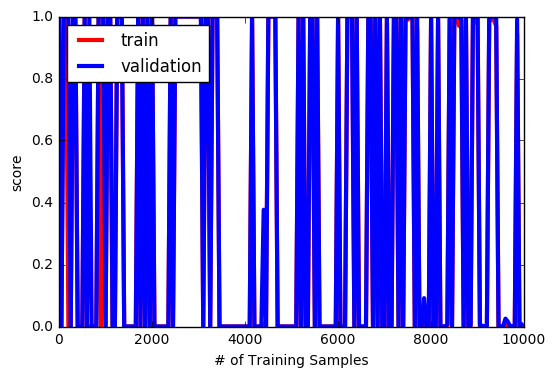

In [58]:
trainer.computeLearningCurve(10, 10000, 50)

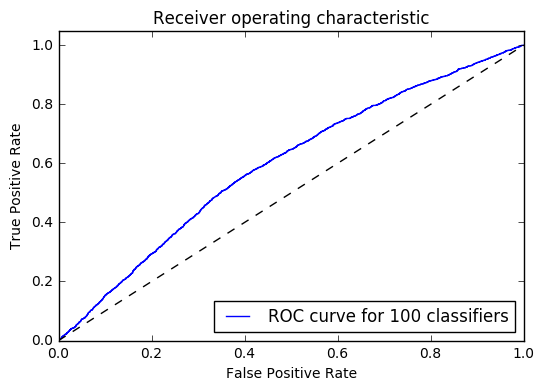

In [18]:
trainer.computeROC()

Opening learningcurve.txt
200
200


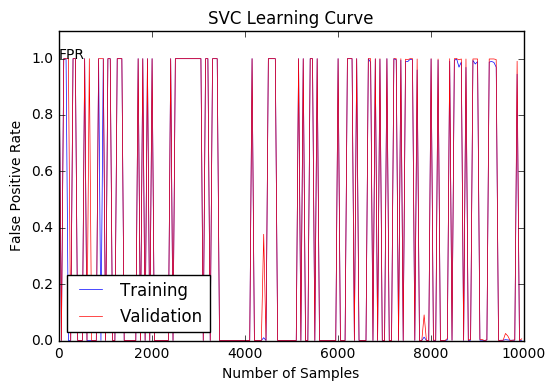

In [73]:
trainer.computeLearningCurve(10,10000,50)